[Source](https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html)

### Distribution of the data vs uncertainty

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import random

In [3]:
random.gauss(0,100)

20.216987462213176

In [4]:
def generate_time_series(k=200, m=1000, sigma=100, n=50,start_date=dt.date(2017,7,1)):
    xs = np.linspace(0, 1, n, endpoint = False)
    ys = [k*x+m+random.gauss(0,sigma) for x in xs]
    ts = [start_date+dt.timedelta(x)*365 for x in xs]
    x_scale = np.linspace(-1,2,500) #for plotting
    t_scale = [start_date +dt.timedelta(x)*365 for x in x_scale]
    return xs, ys, ts, x_scale, t_scale

xs, ys, ts, x_scale, t_scale = generate_time_series()


Text(0,0.5,'Wt of elephant(kg)')

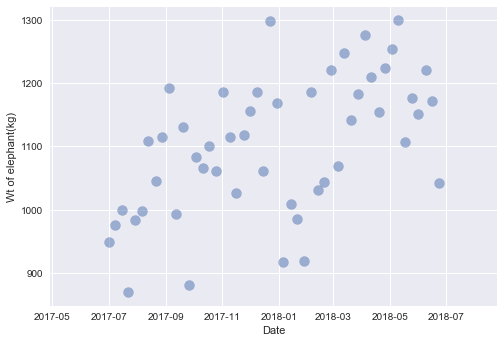

In [5]:
plt.style.use('seaborn')
plt.scatter(ts,ys, alpha = .5, s = 100)
plt.xlabel('Date')
plt.ylabel('Wt of elephant(kg)')

In [6]:
d = pd.DataFrame({'x': xs, 't': ts, 'weight': ys})
d['month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
d.head(10)

,x,t,weight,month
0,0.00,2017-07-01,948.811896,2017-07
1,0.02,2017-07-08,976.291039,2017-07
2,0.04,2017-07-15,999.204227,2017-07
3,0.06,2017-07-22,869.612686,2017-07
4,0.08,2017-07-30,983.419915,2017-07
5,0.10,2017-08-06,998.230875,2017-08
6,0.12,2017-08-13,1108.390494,2017-08
7,0.14,2017-08-21,1044.987616,2017-08
8,0.16,2017-08-28,1114.140788,2017-08
9,0.18,2017-09-04,1192.174008,2017-09


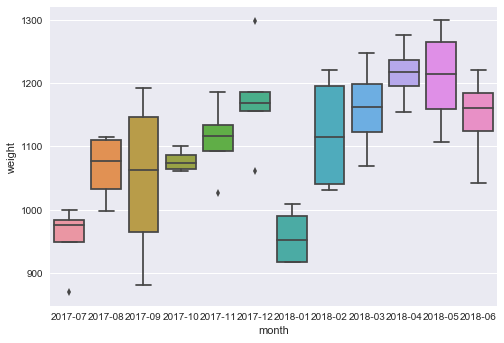

In [7]:
sns.boxplot(data = d, x = 'month', y = 'weight')

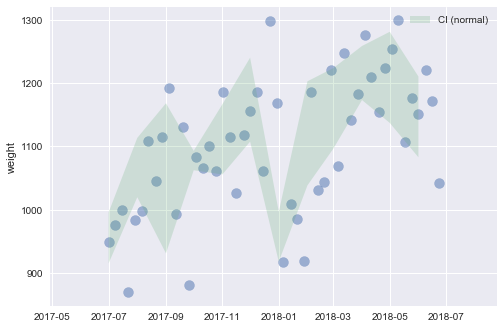

In [8]:
def plot_ci(observations_by_grp):
    groups = list(sorted(observations_by_grp.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_grp[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu-1.96*std*n**-0.5)
        hi_bound.append(mu+1.96*std*n**-0.5)
    plt.fill_between(groups, lo_bound, hi_bound, alpha = .2, label = 'CI (normal)')
    
plt.scatter(ts,ys, alpha =.5, s =100)    
observations_by_month = {}
for month, y in zip(d['month'],d['weight']):
    observations_by_month.setdefault(month,[]).append(y)

plot_ci(observations_by_month)
plt.ylabel('weight')
plt.legend()

In [10]:
%pprint
observations_by_month

Pretty printing has been turned OFF


{'2017-07': [948.8118959809352, 976.2910385672067, 999.2042267668985, 869.6126855445857, 983.4199149010615], '2017-08': [998.2308751811628, 1108.3904939337936, 1044.987615518252, 1114.1407879014491], '2017-09': [1192.174007824946, 992.6955967963971, 1131.2418062280776, 881.608078698253], '2017-10': [1082.4343661976707, 1066.0564550026384, 1100.7500085227248, 1060.73124888085], '2017-11': [1185.7126889527697, 1114.223842094371, 1026.4952235794099, 1117.287611064812], '2017-12': [1156.178202919574, 1185.7757873073626, 1060.6329297930645, 1297.4133474277608, 1168.2356594439161], '2018-01': [917.3065284594069, 1008.1631663743739, 984.5866097419732, 918.2530643293002], '2018-02': [1186.1225308593719, 1031.3596942148897, 1043.8798970242865, 1220.4819790676147], '2018-03': [1068.275963515508, 1247.123454530417, 1141.5379169916714, 1182.5571890059732], '2018-04': [1275.6444978912118, 1209.8166814807655, 1153.3926965367182, 1223.9858597170476], '2018-05': [1253.6175866469796, 1298.7536343641286

In [15]:
groups = list(sorted(observations_by_month.keys()))
lo_bound = []
hi_bound = []
for group in groups:
    series = observations_by_month[group]
    mu, std, n = np.mean(series), np.std(series), len(series)
    lo_bound.append(mu-1.96*std*n**-0.5)
    hi_bound.append(mu+1.96*std*n**-0.5)

In [16]:
lo_bound

[915.217349680829, 1019.5715658723349, 930.9633017199806, 1062.1766479065864, 1055.5512765160477, 1107.386617311112, 917.7075470178695, 1038.293794880277, 1096.2615022439095, 1173.0523130340991, 1136.925938773422, 1082.6865489952465]

In [17]:
hi_bound

[995.7185550234461, 1113.303320394994, 1167.8964430538565, 1092.8093913953558, 1166.3084063296335, 1239.907753445559, 996.4471374346576, 1202.6282557028048, 1223.4857597778755, 1258.3675547787723, 1280.795754563149, 1210.1983185692934]

### Confidence intervals when all outcomes are 0 or 1

In [7]:
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def gen_binary_categorical(states = STATES, groups = GROUPS, k=400, zs =[0,0.2],z_std =.1, b=-3, b_std =1):
    op = {}
    e_obs_per_state = np.random.exponential(k, size = len(states))
    state_biases = np.random.normal(b, b_std, size = len(states))
    for group, z in zip(groups, zs):
        noise = np.random.normal(z, z_std, size = len(states))
        ps = 1/(1+np.exp(-(state_biases + noise)))
        ns = np.random.poisson(e_obs_per_state)
        ks = np.random.binomial(ns,ps)
        op[group] = (ns,ks)
    return op


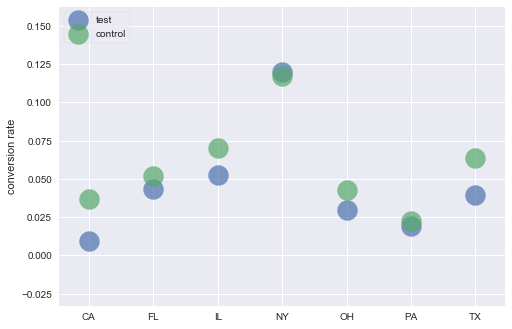

In [8]:
data = gen_binary_categorical()
for group, (ns,ks) in data.items():
    plt.scatter(STATES, ks/ns, label = group, alpha = .7, s =400)
 
plt.ylabel('conversion rate')
plt.legend(loc = 'upper left', frameon = True)

In [9]:
data.items()

dict_items([('test', (array([212, 674,  69, 965, 157, 322,  68]), array([ 2, 81,  3, 38,  3, 17,  2]))), ('control', (array([ 215,  630,   58, 1008,  135,  343,   93]), array([ 8, 74,  3, 64,  3, 24,  4])))])

In [10]:
for group, (ns,ks) in data.items():
    print(group,(ns/ks))

test [106.           8.32098765  23.          25.39473684  52.33333333
  18.94117647  34.        ]
control [26.875       8.51351351 19.33333333 15.75       45.         14.29166667
 23.25      ]


##### trick

Since all outcomes are 0 or 1, and drawn with the same (unknown) probability, we know that the number of ones and zeros follows a binomial distribution. This means that the confidence interval of a “k out of n” scenario is a Beta distribution.

Use following formula for CI for such a case -

`scipy.stats.beta.ppf([0.025,0.975], k, n-k)`

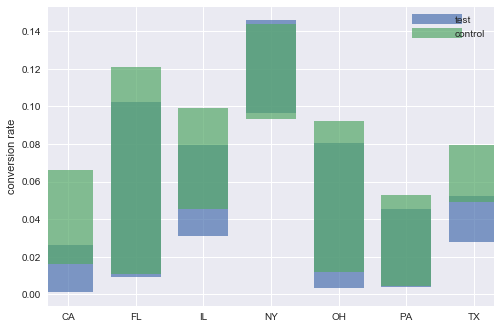

In [11]:
from scipy import stats
for group, (ns,ks) in data.items():
    lo = stats.beta.ppf(0.025, ks, ns-ks)
    hi = stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    plt.errorbar(STATES, y =mean, yerr = [mean-lo, hi-mean], label = group, alpha =.7, linewidth =0, elinewidth =50)
    
plt.ylabel('conversion rate')
plt.legend()

### Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas. The idea is to compute the mean, but do it for n bootstraps, where each bootstrap is a random sample (with replacement) from our observations. For every bootstrap, we compute a mean, and then we take the mean in the 97.5th and the 2.5th percentile as the confidence interval:

In [21]:
series = observations_by_month['2017-07']
btm = []
bt = [random.choice(series) for _ in series]
bt

[976.2910385672067, 869.6126855445857, 976.2910385672067, 983.4199149010615, 983.4199149010615]

In [22]:
series


[948.8118959809352, 976.2910385672067, 999.2042267668985, 869.6126855445857, 983.4199149010615]

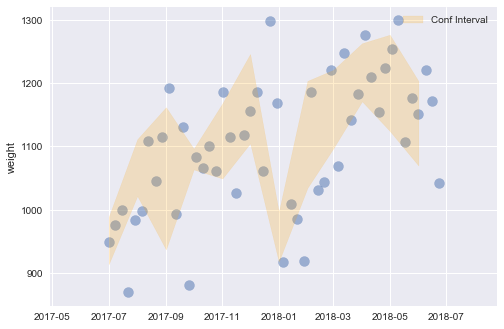

In [18]:
lo_bound = []
hi_bound = []
months = sorted(observations_by_month.keys())
for month in months:
    series = observations_by_month[month]
    bootstrapped_mean = []
    for i in range(1000):
        bootstrap = [random.choice(series) for _ in series]
        bootstrapped_mean.append(np.mean(bootstrap))
    lo_bound.append(np.percentile(bootstrapped_mean,2.5))
    hi_bound.append(np.percentile(bootstrapped_mean,97.5))
    
plt.scatter(ts,ys, alpha=.5, s=100)
plt.fill_between(months, lo_bound, hi_bound, alpha = .2, label = 'Conf Interval', color = 'orange')
plt.ylabel('weight')
plt.legend()

As a side note, Seaborn’s barplot actually plots confidence intervals using bootstrapping:

C:\miniconda3\envs\data\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


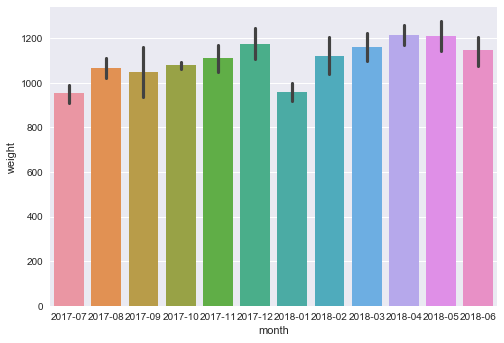

In [24]:
sns.barplot(data =d, x = 'month', y ='weight')


### Regression



Let’s crank it up a notch. We’re going to fit a straight line to this cloud of points.

There’s some smart ways you can implement linear regression so that it’s extremely fast, but we’re not going to use those methods because they don’t generalize very well.

I’m going to do it in what I think of as the most general possible way. We’re going to define a model (in this case a straight line), a loss function (squared deviations from this straight line) and then optimize it using a general-purpose solver (`scipy.optimize.minimize`).

Text(0,0.5,'weight')

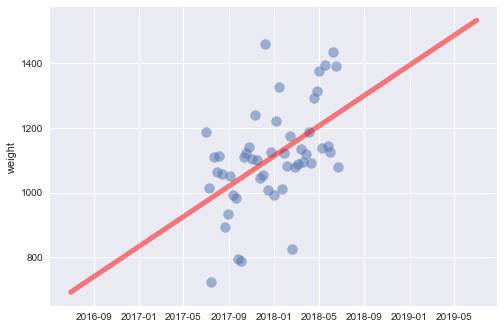

In [14]:
import scipy
xs, ys, ts, x_scale, t_scale = generate_time_series()

def model(xs, k, m):
    return k*xs+m

def l2_loss(tup, xs, ys):
    k,m = tup
    delta = model(xs, k, m) - ys
    return np.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0,0), args = (xs,ys)).x
plt.scatter(ts, ys, alpha = .5, s = 100)
plt.plot(t_scale, model(x_scale, k_hat, m_hat), color = 'red', linewidth =5, alpha =.5)
plt.ylabel('weight')


### Linear regression with uncertainty, using maximum likelihood

We just fit `k` and `m` but there’s no uncertainty estimates here. There’s several things we could estimate uncertainties for, but let’s start with the uncertainty of the predicted values.

We can do that by fitting a normal distribution around the line at the same time as we’re fitting `k`
and `m`. I’m going to do this using **Maximum Likelihood**. 

In fact, minimizing squared loss (which we just did, in the previous snippet) is actually a special case of maximum likelihood! Minimizing the squared loss is the same thing as maximizing the logarithm of the probability of all the data. This is usually called the “log likelihood”.

So we already have an expression to minimize the squared loss. If we make the variance an unknown variable $\sigma^2$

we can fit that at the same time! The quantity we’re going to try to minimize now turns into

$$\frac{n}{2}\log{2}\pi\sigma^2+\frac{1}{2\sigma^2}∑{(y_i−\hat{y}_i)}^2$$

where $\hat{y}_i=kx_i+m$ are the predicted values by our model. Let’s try to fit that-

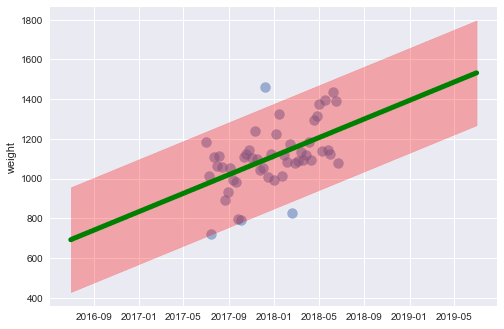

In [15]:
def neg_log_likelihood(tup, xs, ys):
    k,m, log_sigma = tup
    sigma = np.exp(log_sigma)
    delta = model(xs, k, m) - ys
    return len(xs)/2*np.log(2*np.pi*sigma**2)+ np.dot(delta,delta)/(2*sigma**2)

k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(neg_log_likelihood, (0,0,0), args = (xs,ys)).x
sigma_hat = np.exp(log_sigma_hat)
plt.scatter(ts, ys, alpha = .5, s =100)
plt.plot(t_scale, model(x_scale, k_hat, m_hat), color = 'green', linewidth =5)
plt.fill_between(t_scale, model(x_scale, k_hat, m_hat)-1.96*sigma_hat,
                model(x_scale, k_hat, m_hat)+1.96*sigma_hat, color = 'red', alpha = .3)

plt.ylabel('weight')
plt.legend()

The uncertainty estimate here isn’t actually 💯 because it doesn’t take into account the uncertainty of `k`, `m`, and `σ` in itself. It’s a decent approximation, but to get it right we need to do those things at the same time. So let’s do it.

### Bootstrapping, rebooted

So let’s take it to the next level and try to estimate the uncertainty estimate of `k` and `m` and `σ`. I think this will show how bootstrapping is basically cookie cutter — you can plug it into almost anything in order to estimate uncertainties.

For every bootstrap estimate, I’m going to draw a line. We can also take all those lines and compute a confidence interval:

Text(0,0.5,'weight')

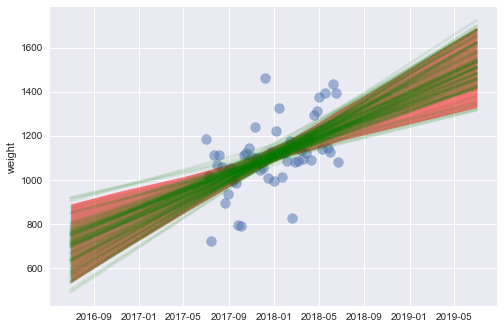

In [16]:
plt.scatter(ts, ys, alpha = .5, s = 100)
xys = list(zip(xs, ys))
curves = []
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x, y in bootstrap])
    ys_bootstrap = np.array([y for x, y in bootstrap]) 
    k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0,0), args = (xs_bootstrap, ys_bootstrap)).x
    curves.append(model(x_scale, k_hat, m_hat))

for curve in curves:
    plt.plot(t_scale, curve, alpha=.1, linewidth=3, color = 'green')
    
lo,hi = np.percentile(curves,(2.5,97.5), axis = 0)
plt.fill_between(t_scale, lo, hi, color = 'red', alpha = .5)
plt.ylabel('weight')

This uncertainty is very different from the earlier plot. This seems confusing until you realize that they show two very different things:

 - The first plot finds one solution of `k` and `m` and shows the uncertainty of the predictions. So, if you’re asked what’s the range of the elephant’s weight in the next month, you can get it from the chart.

 - The second plot finds many solutions of k and m, and shows the uncertainty of kx+m. So this answers a different question – what’s the trend of the elephant’s weight over time and what’s the uncertainty of the trend.

It turns out we can combine the two approaches and make it even more complicated by fitting drawing bootstrap samples and fitting `k`, `m`, and `σ` at the same time. Then for each of those estimates, we can predict new values y. Let’s do it.

Text(0,0.5,'weight')

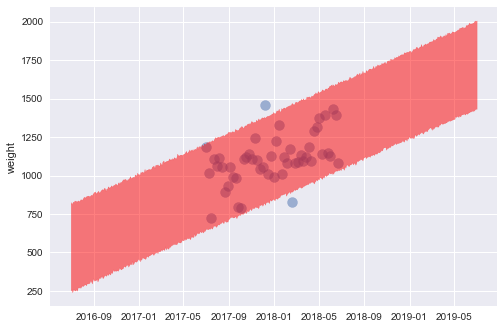

In [17]:
plt.scatter(ts, ys, alpha = .5, s = 100)
xys = list(zip(xs,ys))
curve = []
for i in range(4000):
    bootsrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x,y in bootstrap])
    ys_bootstrap = np.array([y for x,y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
    neg_log_likelihood, (0,0,0), args = (xs_bootstrap, ys_bootstrap)).x
    curves.append(model(x_scale, k_hat, m_hat)+np.exp(log_sigma_hat)*np.random.normal(size  = x_scale.shape))
    
lo,hi = np.percentile(curves,(2.5,97.5), axis = 0)
plt.fill_between(t_scale, lo, hi, color = 'red', alpha = .5)
plt.ylabel('weight')        

You can see a hyperbolic shape if you look closely!

The trick here is that for every bootstrap estimates of (`k`,`m`,`σ`) we also need to draw random predictions. As you can see in the code, we’re actually adding random normal variables to the predicted values for `y`. That’s also why the shape end up a big squiggly.

Unfortunately bootstrapping turns out to be fairly slow for this problem – for each of the bootstraps, we need to fit a model. Let’s look at another option:

### Markov Chain Monte Carlo Methods

We're going to switch to some Bayesian methods, where we estimate `k`, `m`, and `σ` by drawing samples. It’s similar to bootstrapping, but MCMC has far better theoretical underpinnings (we are sampling from a “posterior distribution” using Bayes rule), and it’s often orders of magnitude faster.

For this, we’re going to use a library called emcee which I’ve found pretty easy to use. All it needs is a log-likelihood function, which as it turns out we just defined earlier! We just need to take the negative of it.

In [19]:

#need to install emcee
import emcee
xs, ys, ts, x_scale, t_scale = generate_time_series()

def log_likelihood(tup, xs, ys):
    return -neg_log_likelihood(tup, xs, ys)

ndim, nwalkers = 3,10
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args = [xs, ys])

sampler.run_mcmc(p0,10000)




(array([[ 199.1381478 , 1011.16792898,    4.5489841 ],
        [ 160.054474  , 1034.99869977,    4.57636511],
        [ 173.0632136 , 1001.51245417,    4.73264994],
        [ 154.52527701, 1013.35849423,    4.45486544],
        [ 230.88521589,  987.53297445,    4.56503779],
        [ 215.06146991,  972.42141509,    4.31294964],
        [ 200.80264897,  999.41143291,    4.65148104],
        [ 148.22058536, 1022.49578033,    4.62854224],
        [ 202.09227746,  990.00203897,    4.759624  ],
        [ 270.64802901,  960.05562919,    4.60956247]]),
 array([-299.67784637, -300.24591505, -300.67942359, -300.38450303,
        -299.58319426, -304.59560304, -299.56108761, -299.76507087,
        -300.95488853, -300.56970269]),
 ('MT19937', array([ 316785157, 2577720293,  484940892, 2131112434, 3448144826,
          132943810, 2949410940, 2810130049, 2459190700, 1355235610,
         4208389227, 4127241679, 2600213152,  694233981,  957766328,
          809813531, 2985731647, 3904078306, 353833874

Let’s plot the sampled values for `k` and `m`.

ERROR:root:Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


Text(0,0.5,'weight')

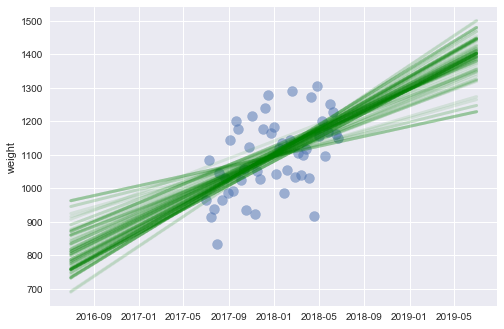

In [20]:
samples = sampler.chain[:, -10:, :].reshape((-1, ndim))

plt.scatter(ts, ys, alpha=.5, s = 100)
for k, m , log_sigma in samples:
    plt.plot(t_scale, model(x_scale, k, m), alpha = .1, linewidth=3, color = 'green')

plt.ylabel('weight')

C:\miniconda3\envs\data\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


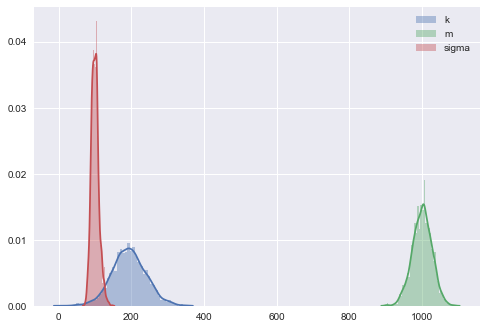

In [21]:
samples = sampler.chain[:,-500:, :].reshape((-1, ndim))
k_samples, m_samples, log_sigma_samples = samples.T
sns.distplot(k_samples, label = 'k')
sns.distplot(m_samples, label = 'm')
sns.distplot(np.exp(log_sigma_samples), label = 'sigma')
plt.legend()

Text(0,0.5,'weight')

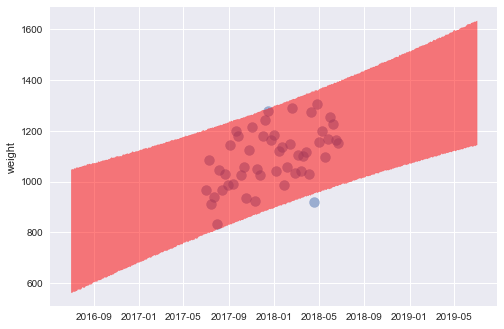

In [22]:
plt.scatter(ts, ys, alpha = .5, s =100)
samples = sampler.chain[:,-4000:,:].reshape((-1,ndim))
curves = []
for k,m, log_sigma in samples:
    curves.append(
    model(x_scale, k, m)+
    np.exp(log_sigma)*np.random.normal(size=x_scale.shape))
    
lo, hi = np.percentile(curves, (2.5,97.5), axis = 0) 
plt.fill_between(t_scale, lo, hi, color = 'red', alpha = .5)
plt.ylabel('weight')